In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from itertools import combinations
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.stats import mode
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.kernel_approximation import RBFSampler
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.metrics import classification_report, make_scorer, f1_score, confusion_matrix, silhouette_score, ConfusionMatrixDisplay, adjusted_rand_score
from matplotlib.patches import Patch

In [ ]:
#load dataset
column_names = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'grade_of_spondylolisthesis', 'label']
vertebral = pd.read_csv('vertebral_column_data.txt', delimiter=' ', header=None, names=column_names)

In [ ]:
#transform grade_of_spondylolisthesis to log_grade_of_spondylolisthesis

#add offset to avoid 0 for log_grade_of_spondylolisthesis
offset = np.abs(np.min(vertebral['grade_of_spondylolisthesis'])) + 1
vertebral_df = vertebral.copy()
#add new column log_grade_of_spondylolisthesis
vertebral_df['log_grade_of_spondylolisthesis'] = np.round(np.log(vertebral['grade_of_spondylolisthesis'] + offset),2)
#drop grade_of_spondylolisthesis
vertebral_df = vertebral_df.drop('grade_of_spondylolisthesis', axis=1)

In [ ]:
y = vertebral_df['label']
X = vertebral_df.drop('label', axis=1)

In [ ]:
#oversampling dataset using SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [ ]:
#scaling dataset
numeric_cols = X_res.columns.tolist() #add feature names
scaler = StandardScaler() #initialise scaler
X_scaled = scaler.fit_transform(X_res) #scaling
X_scaled = pd.DataFrame(X_scaled, columns = numeric_cols) #convert to data frame
scaled_vertebral = pd.concat([X_scaled, y_res], axis=1) #combine with label

In [ ]:
#feature selection (F1-Score)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_res, test_size=0.3, random_state=42)

#set up best score and feature combination storage
max_score = 0
best_combination = None
all_scores = []

#evaluate all possible combinations of features
for L in range(1, len(X_scaled.columns) + 1):
    for subset in itertools.combinations(X_scaled.columns, L):
        #select only the columns for the current features combination
        X_subset_train = X_train[list(subset)]
        X_subset_test = X_test[list(subset)]

        #train the SVM classifier
        classifier = SVC(kernel='rbf')
        classifier.fit(X_subset_train, y_train)

        #make predictions and evaluate using F1 score
        y_pred = classifier.predict(X_subset_test)
        score = f1_score(y_test, y_pred, pos_label='AB')

        #save the score and combination
        all_scores.append((subset, score))

        #update the best score and combination if score is higher
        if score > max_score:
            max_score = score
            best_combination = subset

#print all feature combinations with F1 scores
for combination, score in all_scores:
    print(f'Feature combination: {combination}, F1 score: {score}')

#print the best feature combination and F1 score
print(f'Best feature combination: {best_combination}, Best F1 score: {max_score}')


Feature combination: ('pelvic_incidence',), F1 score: 0.5961538461538461
Feature combination: ('pelvic_tilt',), F1 score: 0.5765765765765766
Feature combination: ('lumbar_lordosis_angle',), F1 score: 0.5102040816326531
Feature combination: ('sacral_slope',), F1 score: 0.5660377358490566
Feature combination: ('pelvic_radius',), F1 score: 0.6226415094339622
Feature combination: ('log_grade_of_spondylolisthesis',), F1 score: 0.7857142857142857
Feature combination: ('pelvic_incidence', 'pelvic_tilt'), F1 score: 0.6407766990291263
Feature combination: ('pelvic_incidence', 'lumbar_lordosis_angle'), F1 score: 0.6285714285714286
Feature combination: ('pelvic_incidence', 'sacral_slope'), F1 score: 0.7037037037037037
Feature combination: ('pelvic_incidence', 'pelvic_radius'), F1 score: 0.8034188034188035
Feature combination: ('pelvic_incidence', 'log_grade_of_spondylolisthesis'), F1 score: 0.7857142857142857
Feature combination: ('pelvic_tilt', 'lumbar_lordosis_angle'), F1 score: 0.5544554455445

In [ ]:
features_comb = pd.DataFrame(all_scores, columns=['Feature Combination', 'F1 Score'])
features_comb.sort_values('F1 Score', ascending=False)

,Feature Combination,F1 Score
49,"(pelvic_incidence, lumbar_lordosis_angle, pelv...",0.876033
46,"(pelvic_incidence, pelvic_tilt, pelvic_radius,...",0.870968
58,"(pelvic_incidence, pelvic_tilt, lumbar_lordosi...",0.870968
53,"(pelvic_tilt, lumbar_lordosis_angle, pelvic_ra...",0.857143
60,"(pelvic_incidence, lumbar_lordosis_angle, sacr...",0.857143
...,...,...
0,"(pelvic_incidence,)",0.596154
1,"(pelvic_tilt,)",0.576577
3,"(sacral_slope,)",0.566038
11,"(pelvic_tilt, lumbar_lordosis_angle)",0.554455


In [ ]:
#feature selection (Silhouette Score)

#set up max score and feature combination storage
max_score = -1
best_combination = None
all_scores = []

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_res, test_size=0.3, random_state=42)

#evaluate all possible combinations of features
for L in range(2, len(X_scaled.columns) + 1):  #start from 2 since silhouette requires multiple clusters to compute
    for subset in itertools.combinations(X_scaled.columns, L):
        ##select only the columns for the current features combination
        X_subset = X_train[list(subset)]

        #initialise kmeans
        kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
        cluster_labels = kmeans.fit_predict(X_subset)

        #compute the silhouette score
        score = silhouette_score(X_subset, cluster_labels)

        #Save the score and features combination
        all_scores.append((subset, score))

        #update the best score and combination if score is higher
        if score > max_score:
            max_score = score
            best_combination = subset

#print all feature combinations with silhouette scores
for combination, score in all_scores:
    print(f'Feature combination: {combination}, Silhouette score: {score}')

#print the best feature combination and silhouette score
print(f'Best feature combination: {best_combination}, Best Silhouette score: {max_score}')

Feature combination: ('pelvic_incidence', 'pelvic_tilt'), Silhouette score: 0.4908781457986007
Feature combination: ('pelvic_incidence', 'lumbar_lordosis_angle'), Silhouette score: 0.5253739401476062
Feature combination: ('pelvic_incidence', 'sacral_slope'), Silhouette score: 0.5267502384650069
Feature combination: ('pelvic_incidence', 'pelvic_radius'), Silhouette score: 0.41464873499094534
Feature combination: ('pelvic_incidence', 'log_grade_of_spondylolisthesis'), Silhouette score: 0.5127399582704604
Feature combination: ('pelvic_tilt', 'lumbar_lordosis_angle'), Silhouette score: 0.46519901242156136
Feature combination: ('pelvic_tilt', 'sacral_slope'), Silhouette score: 0.3827250320799264
Feature combination: ('pelvic_tilt', 'pelvic_radius'), Silhouette score: 0.3280394300783544
Feature combination: ('pelvic_tilt', 'log_grade_of_spondylolisthesis'), Silhouette score: 0.4747176971499376
Feature combination: ('lumbar_lordosis_angle', 'sacral_slope'), Silhouette score: 0.501349224512570

In [ ]:
features_comb = pd.DataFrame(all_scores, columns=['Feature Combination', 'Silhoutte Score'])
features_comb.sort_values('Silhoutte Score', ascending=False)

,Feature Combination,Silhoutte Score
11,"(lumbar_lordosis_angle, log_grade_of_spondylol...",0.532718
2,"(pelvic_incidence, sacral_slope)",0.526750
1,"(pelvic_incidence, lumbar_lordosis_angle)",0.525374
4,"(pelvic_incidence, log_grade_of_spondylolisthe...",0.512740
9,"(lumbar_lordosis_angle, sacral_slope)",0.501349
0,"(pelvic_incidence, pelvic_tilt)",0.490878
13,"(sacral_slope, log_grade_of_spondylolisthesis)",0.489740
21,"(pelvic_incidence, lumbar_lordosis_angle, log_...",0.488527
19,"(pelvic_incidence, lumbar_lordosis_angle, sacr...",0.487440
23,"(pelvic_incidence, sacral_slope, log_grade_of_...",0.479191


In [ ]:
X_subset = X_scaled[['pelvic_incidence', 'lumbar_lordosis_angle', 'pelvic_radius', 'log_grade_of_spondylolisthesis']]

# EDA

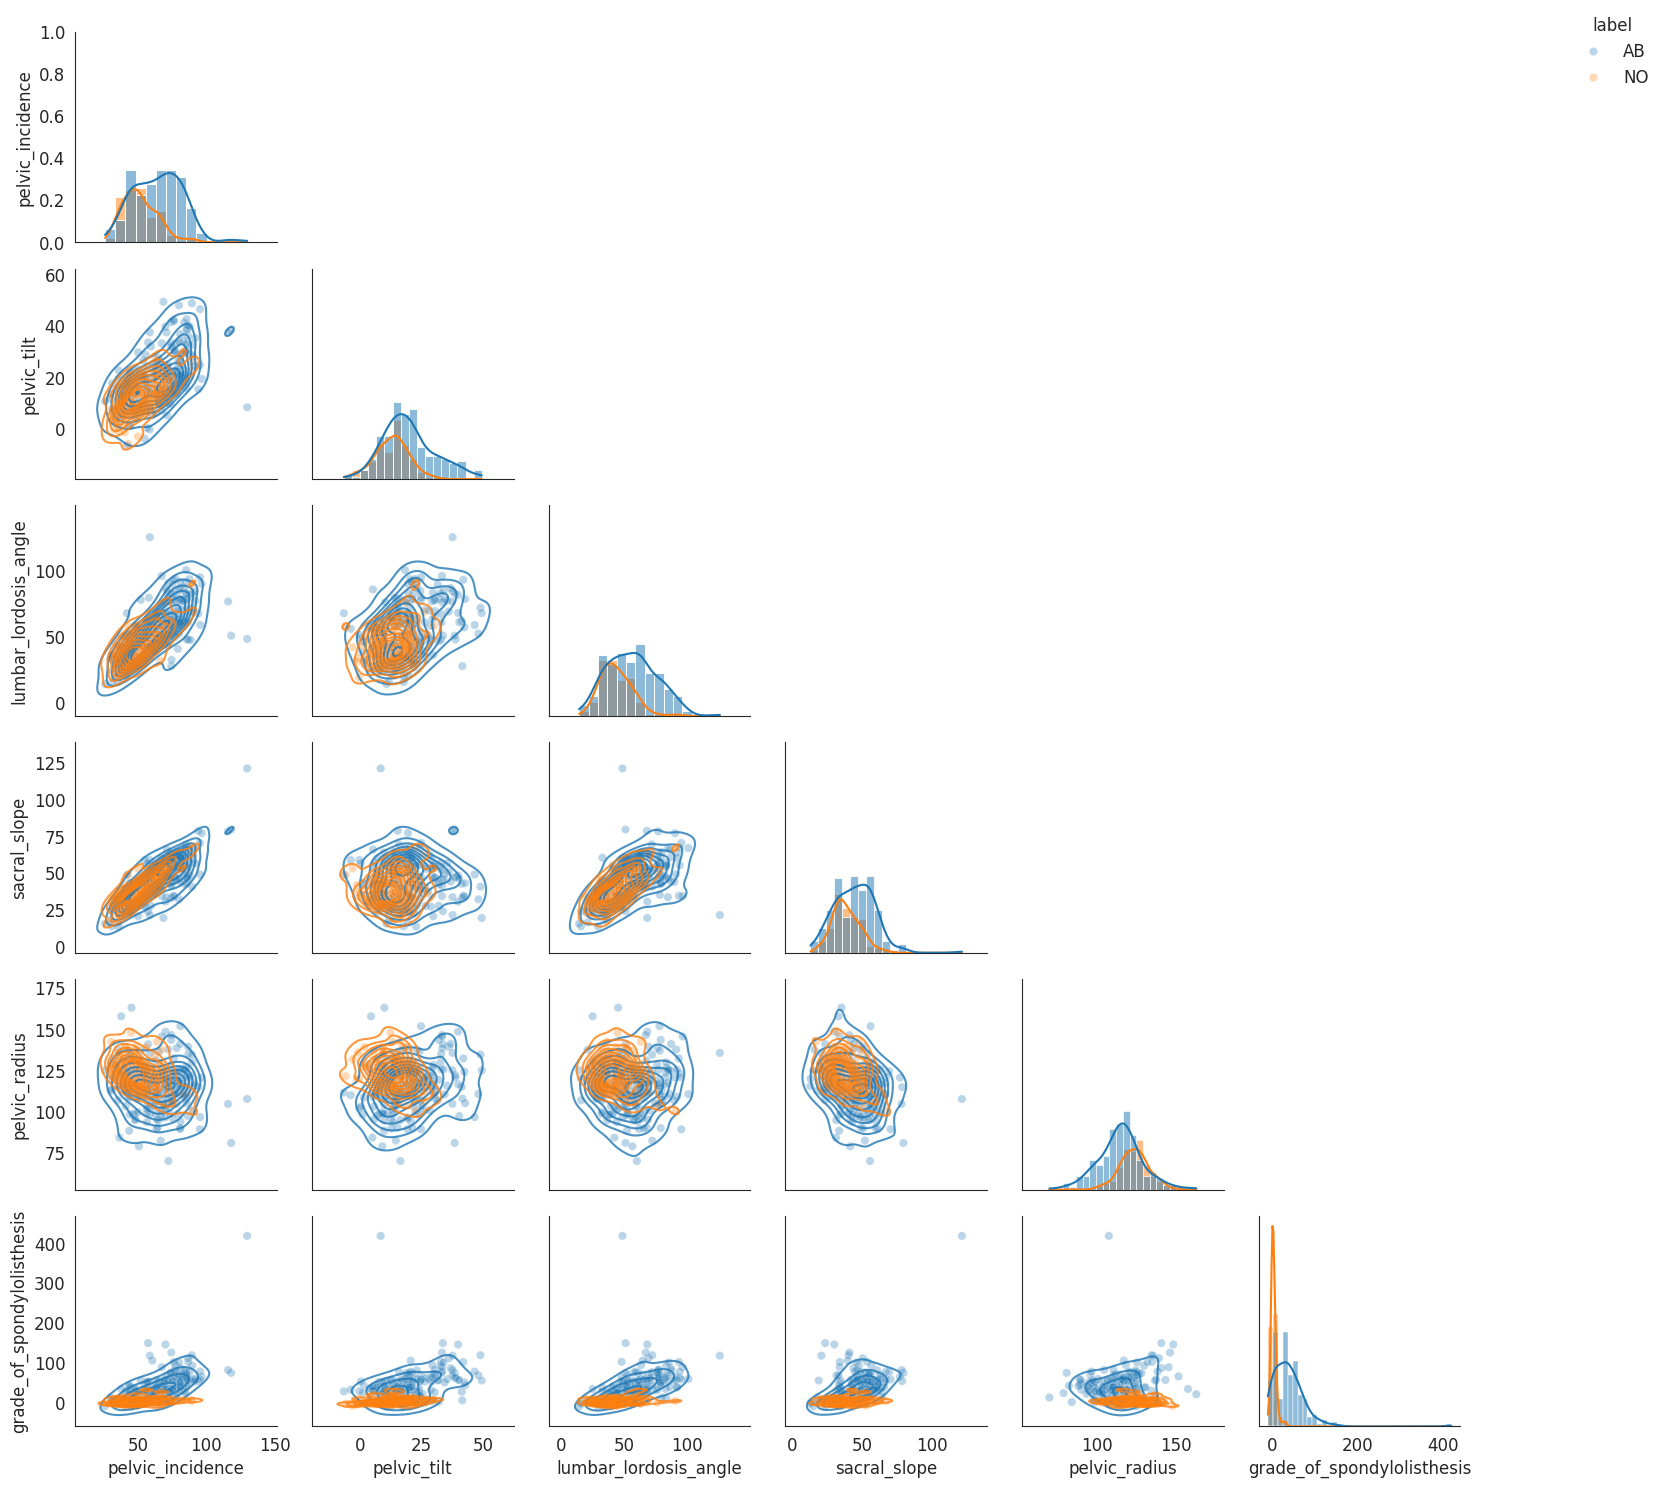

In [ ]:
#initialize the pairgrid
grid = sns.PairGrid(vertebral, hue='label')

#draw kde and scatter plot to the lower diagonal
grid.map_lower(sns.kdeplot, alpha=0.8)
grid.map_lower(sns.scatterplot, alpha=0.3)

#draw histogram to the diagonal
grid.map_diag(sns.histplot, kde=True)

#add legend
grid.add_legend(title='label', bbox_to_anchor=(1, 1), loc='upper left')

#remove upper diagonal plot
for i, j in zip(*np.tril_indices_from(grid.axes, -1)):
    grid.axes[j, i].set_visible(False)

plt.show()

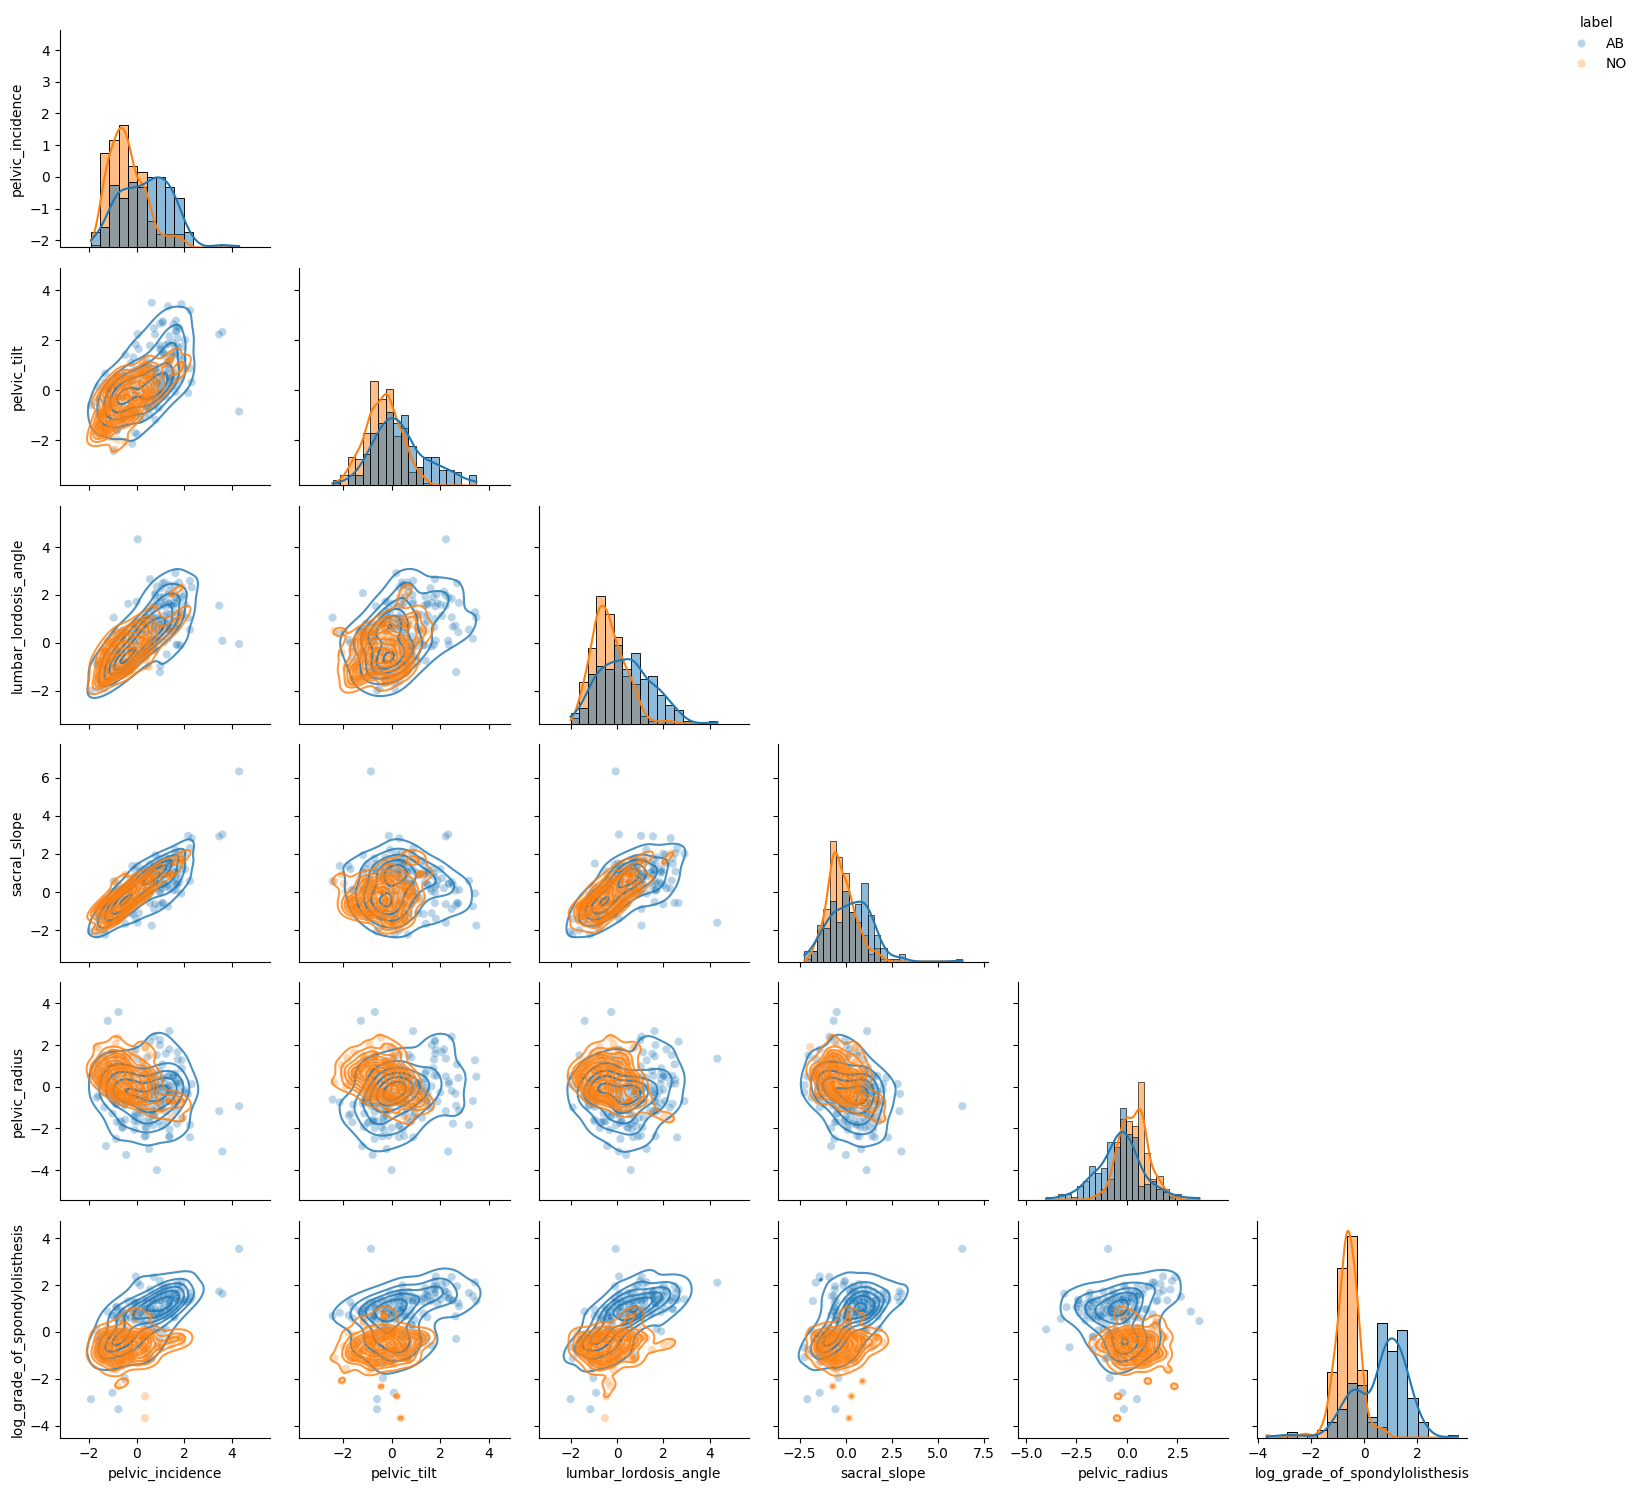

In [ ]:
#multivariate EDA
#initialise the pairgrid
grid = sns.PairGrid(scaled_vertebral, hue='label')

#draw kde and scatter plot to the lower diagonal
grid.map_lower(sns.kdeplot, alpha=0.8)
grid.map_lower(sns.scatterplot, alpha=0.3)

#draw histogram to the diagonal
grid.map_diag(sns.histplot, kde=True)

#add legend
grid.add_legend(title='label', bbox_to_anchor=(1, 1), loc='upper left')

#remove upper diagonal plot
for i, j in zip(*np.tril_indices_from(grid.axes, -1)):
    grid.axes[j, i].set_visible(False)

plt.show()

<Axes: >

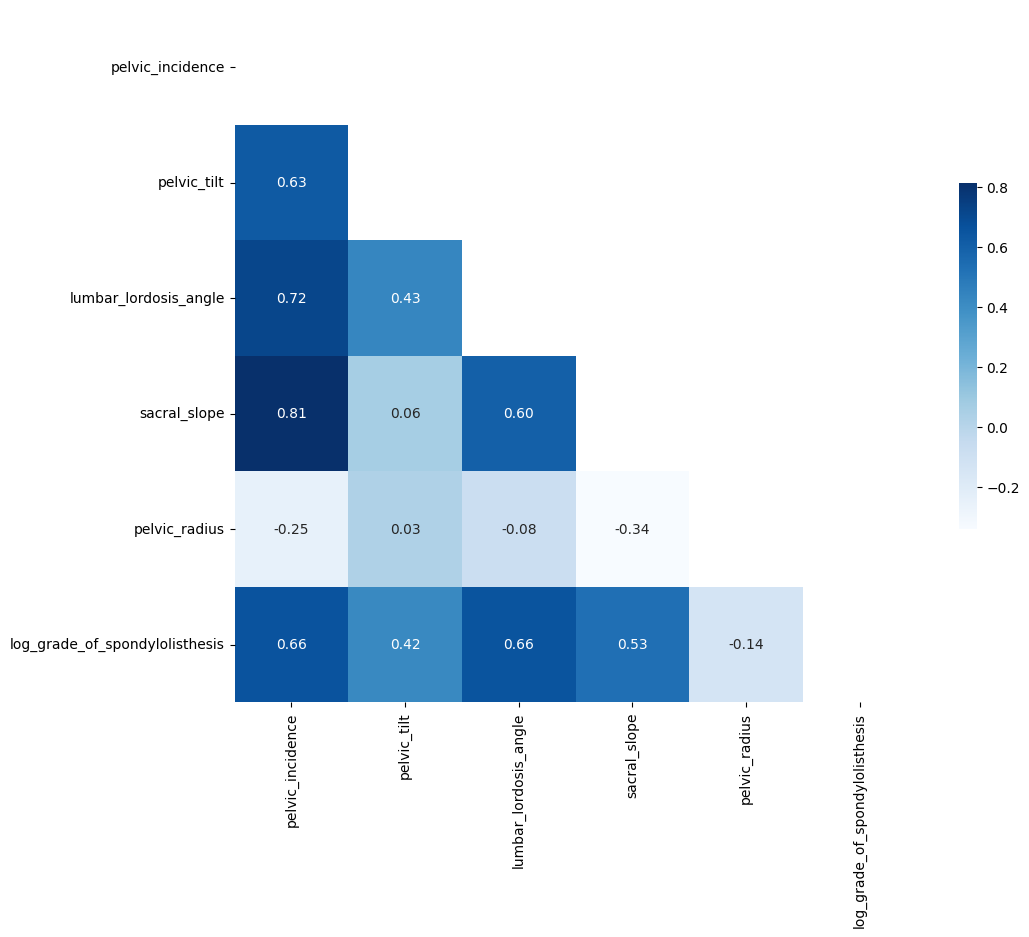

In [ ]:
#draw correlation matrix
#calculate correlation
corr = vertebral_df.corr(numeric_only=True)

#generate a mask to hide the upper diagonal
mask = np.triu(np.ones_like(corr, dtype=bool))

#initialise matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

#draw the heatmap
sns.heatmap(corr, mask=mask, cmap='Blues', cbar_kws={"shrink": .5}, annot=True, fmt='.2f')

# **Unsupervised Classification**

## KMeans Clustering

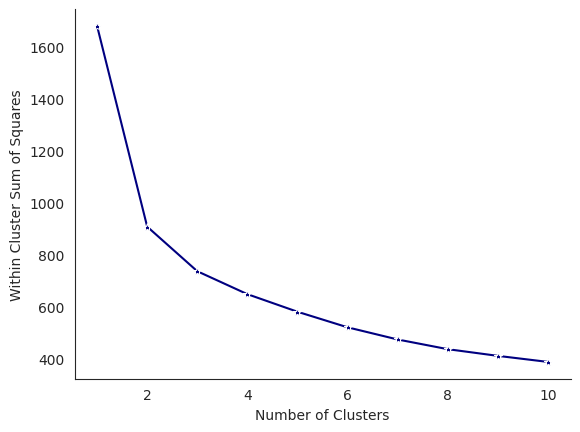

In [ ]:
#draw elbow plot

max_k = 10 #set maximum number of clusters to be checked
sum_of_squares = [] #initialise empty list
#run k-means iteratively for each k number of clusters
for k in range(1,max_k+1):
    kmeans = KMeans(n_clusters = k, n_init = 10) #initialise K-Means for each k
    kmeans.fit(X_subset) #fit to scaled data
    sum_of_squares.append(kmeans.inertia_) #store the within cluster sum of squares in the list

#plotting the elbow plot
sns.set_style('white')
sns.lineplot(x=list(range(1,max_k+1)), y=sum_of_squares,  marker = '*', color='navy')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of Squares')
sns.despine() #remove the top and right border line
plt.show()

In [ ]:
#kmeans with 2 clusters
kmeans = KMeans(n_clusters=2, n_init=4)
kmeans.fit(X_subset)
kmeans_labels = kmeans.labels_

In [ ]:
#calculate Silhoutte Score
score_silhoutte = silhouette_score(X_subset, kmeans_labels)
print('K-Means Silhouette Score:', score_silhoutte)

#calculate ARI
ari_score = adjusted_rand_score(y_res, kmeans_labels)
print('K-Means ARI:', ari_score)

#calculate F1
true_label = np.array(y_res)
labels_con = np.where(kmeans_labels == 1, 'AB', 'NO')
f1 = f1_score(true_label, labels_con, pos_label='AB')
print('K-Means F1:', f1)

K-Means Silhouette Score: 0.43165442129995407
K-Means ARI: 0.272764194657941
K-Means F1: 0.7252747252747251


## Hierarchical Clustering

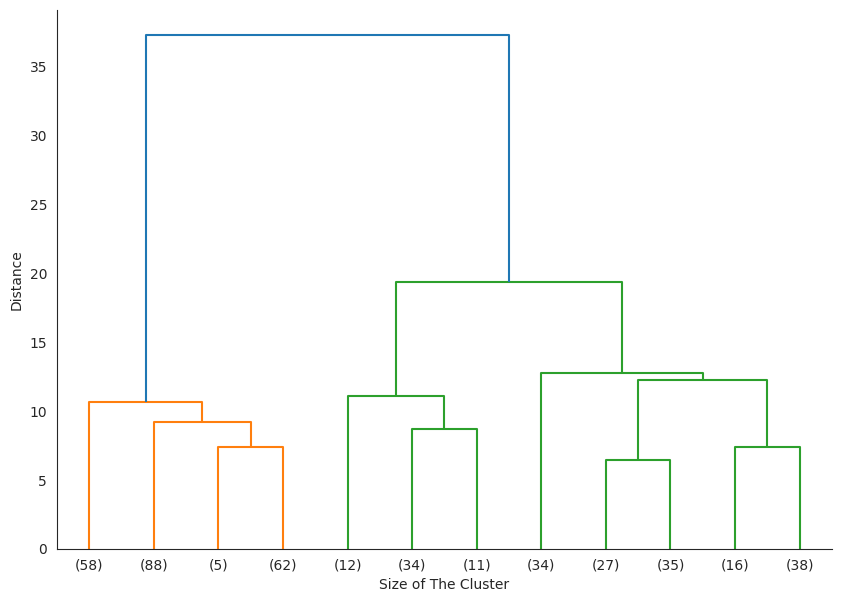

In [ ]:
#draw dendrogram

#generate the linkage matrix
#use ward to minimise within cluster sum of squares
Z = linkage(X_subset, 'ward')

#plot the dendrogram
plt.figure(figsize=(10, 7))
plt.ylabel('Distance')
plt.xlabel('Size of The Cluster')

#create dendrogram
dendrogram(
    Z,
    truncate_mode='lastp',  #truncate to display only the last p merged clusters
    p=12,  #show only the last 12 merged clusters
    leaf_font_size=10,  #font size for the x axis labels
)
sns.despine() #remove spine
plt.show()

In [ ]:
#Agglomerative Clustering with 2 clusters
agg = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
agg_labels = agg.fit_predict(X_subset)

In [ ]:
#calculate Silhoutte Score
score_silhoutte = silhouette_score(X_subset, agg_labels)
print('Hierarchical Silhouette Score:', score_silhoutte)

#calculate ARI
ari_score = adjusted_rand_score(y_res, agg_labels)
print('Hierarchical ARI:', ari_score)

#calculate F1
true_label = np.array(y_res)
labels_con = np.where(agg_labels == 0, 'AB', 'NO')
f1 = f1_score(true_label, labels_con, pos_label='AB')
print('Hierarchical F1:', f1)

Hierarchical Silhouette Score: 0.3634655643140457
Hierarchical ARI: 0.28784718340089127
Hierarchical F1: 0.7673860911270983


## EM Model

In [ ]:
#initialise the Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, random_state=0)

#fit the model and make prediction for the cluster
gmm.fit(X_subset)
gmm_labels = gmm.predict(X_subset)

In [ ]:
#calculate Silhoutte Score
score_silhoutte = silhouette_score(X_subset, gmm_labels)
print('EM Silhouette Score:', score_silhoutte)

#calculate ARI
ari_score = adjusted_rand_score(y_res, gmm_labels)
print('EM ARI:', ari_score)

#calculate F1
true_label = np.array(y_res)
labels_con = np.where(gmm_labels == 0, 'AB', 'NO')
f1 = f1_score(true_label, labels_con, pos_label='AB')
print('EM F1:', f1)

EM Silhouette Score: 0.38703274718051756
EM ARI: 0.4690145159841584
EM F1: 0.8206521739130435


## Clustering Result

In [ ]:
#store cluster results
cluster_results = scaled_vertebral.copy()
cluster_results['cluster'] = gmm_labels

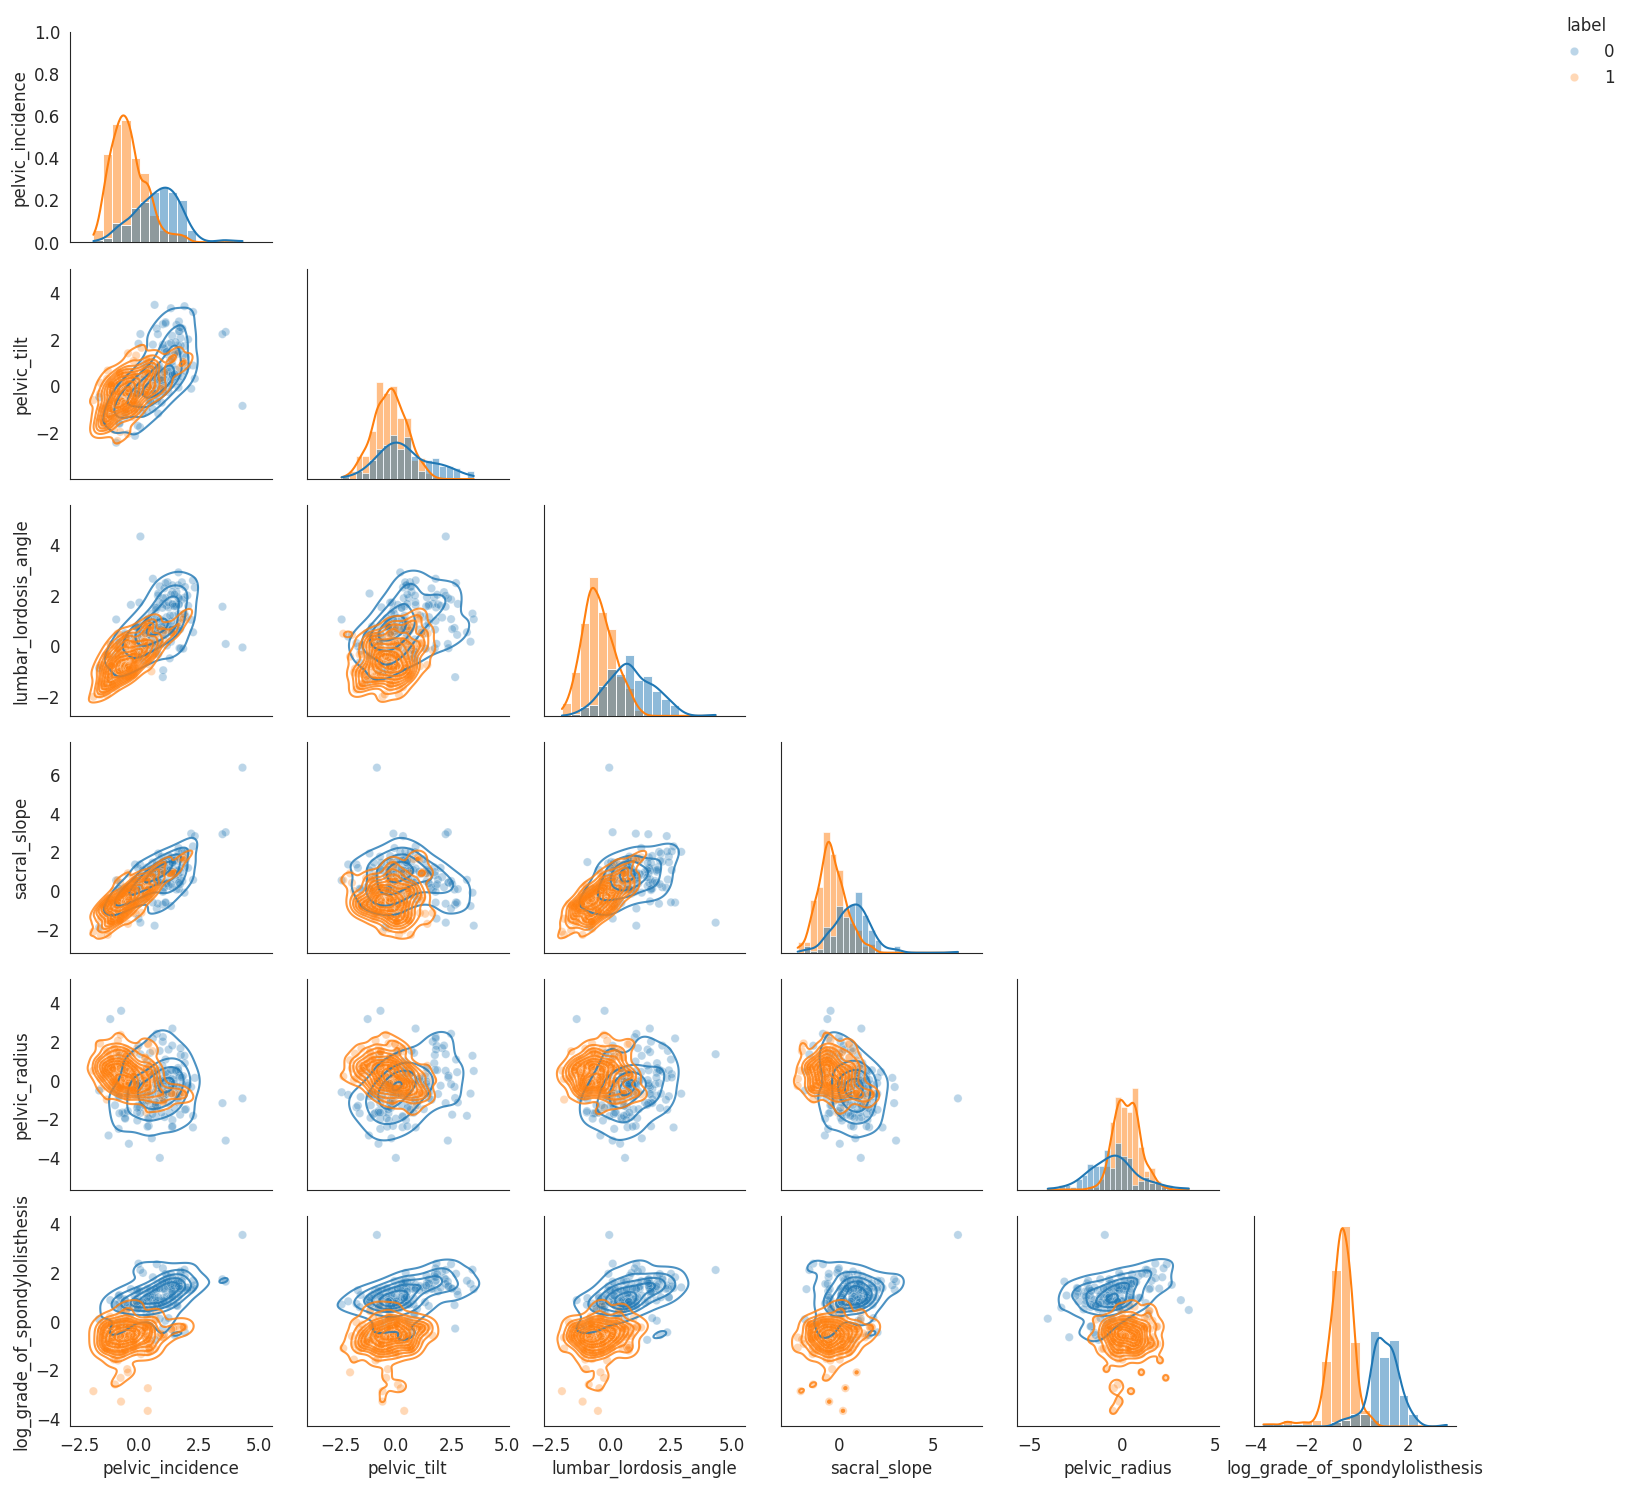

In [ ]:
#initialise the pairgrid
grid = sns.PairGrid(cluster_results, hue='cluster')

#draw kde and scatter plot to the lower diagonal
grid.map_lower(sns.kdeplot, alpha=0.8)
grid.map_lower(sns.scatterplot, alpha=0.3)

#draw histogram to the diagonal
grid.map_diag(sns.histplot, kde=True)

#add legend
grid.add_legend(title='label', bbox_to_anchor=(1, 1), loc='upper left')

#remove upper diagonal plot
for i, j in zip(*np.tril_indices_from(grid.axes, -1)):
    grid.axes[j, i].set_visible(False)

plt.show()

# **Supervised Classification**

In [ ]:
#splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_res, test_size=0.2, stratify=y_res, random_state=42)

## SVM

In [ ]:
#initialise SVM classifier
svm = SVC(kernel='linear', probability=True)
#fit the training data
svm.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [ ]:
#making prediction on training set
y_pred_train = svm.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

          AB       0.95      0.76      0.84       168
          NO       0.80      0.96      0.87       168

    accuracy                           0.86       336
   macro avg       0.87      0.86      0.86       336
weighted avg       0.87      0.86      0.86       336



In [ ]:
#making prediction on test set
y_pred_test = svm.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          AB       0.94      0.76      0.84        42
          NO       0.80      0.95      0.87        42

    accuracy                           0.86        84
   macro avg       0.87      0.86      0.86        84
weighted avg       0.87      0.86      0.86        84



## Random Forest

In [ ]:
#initialise random forest classifier
rf = RandomForestClassifier()
#fit training data
rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
#making prediction on training set
y_pred_trainrf = rf.predict(X_train)
print(classification_report(y_train, y_pred_trainrf))

              precision    recall  f1-score   support

          AB       1.00      1.00      1.00       168
          NO       1.00      1.00      1.00       168

    accuracy                           1.00       336
   macro avg       1.00      1.00      1.00       336
weighted avg       1.00      1.00      1.00       336



In [ ]:
#making prediction on test set
y_pred_testrf = rf.predict(X_test)
print(classification_report(y_test, y_pred_testrf))

              precision    recall  f1-score   support

          AB       0.89      0.76      0.82        42
          NO       0.79      0.90      0.84        42

    accuracy                           0.83        84
   macro avg       0.84      0.83      0.83        84
weighted avg       0.84      0.83      0.83        84



## Naive Bayes Classification

In [ ]:
#initialise naive bayes
nb = GaussianNB()
#fit training data
nb.fit(X_train, y_train)

GaussianNB()

In [ ]:
#making prediction for training set
y_pred_trainnb = nb.predict(X_train)
print(classification_report(y_train, y_pred_trainnb))

              precision    recall  f1-score   support

          AB       0.84      0.74      0.79       168
          NO       0.77      0.86      0.81       168

    accuracy                           0.80       336
   macro avg       0.81      0.80      0.80       336
weighted avg       0.81      0.80      0.80       336



In [ ]:
#making prediction for test set
y_pred_testnb = nb.predict(X_test)
print(classification_report(y_test, y_pred_testnb))

              precision    recall  f1-score   support

          AB       0.86      0.74      0.79        42
          NO       0.77      0.88      0.82        42

    accuracy                           0.81        84
   macro avg       0.82      0.81      0.81        84
weighted avg       0.82      0.81      0.81        84



## HyperParameter Tuning

In [ ]:
#initialise SVM classifier
svm = SVC(probability=True)

#hyperparameters option
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf', 'poly']}

#set custom f1 score for grid search
f1_scorer = make_scorer(f1_score, pos_label='AB')

In [ ]:
#initialise grid search
gs = GridSearchCV(svm, param_grid, refit=True, verbose=2, scoring=f1_scorer, cv=2)

In [ ]:
#fit the training data
gs.fit(X_train, y_train)

Fitting 2 folds for each of 32 candidates, totalling 64 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.01,

GridSearchCV(cv=2, estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly']},
             scoring=make_scorer(f1_score, pos_label=AB), verbose=2)

In [ ]:
#print best parameters
print("Best parameters found: ", gs.best_params_)

Best parameters found:  {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [ ]:
#fit the best model & make prediction on training set
best_model = gs.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          AB       0.95      0.88      0.91       143
          NO       0.89      0.95      0.92       151

    accuracy                           0.92       294
   macro avg       0.92      0.92      0.92       294
weighted avg       0.92      0.92      0.92       294



In [ ]:
#make prediction on test set
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          AB       0.90      0.79      0.84        67
          NO       0.79      0.90      0.84        59

    accuracy                           0.84       126
   macro avg       0.84      0.84      0.84       126
weighted avg       0.85      0.84      0.84       126



<Figure size 300x300 with 0 Axes>

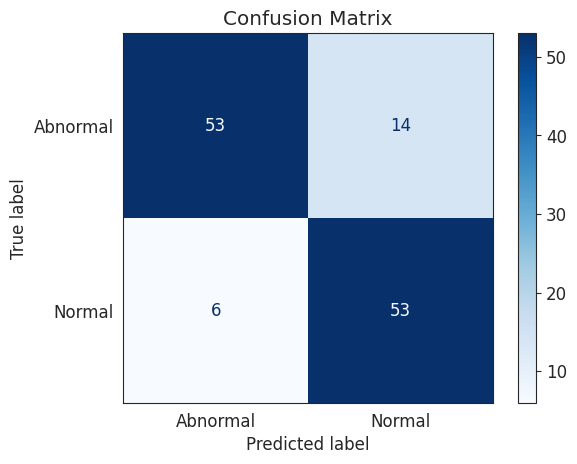

In [ ]:
#compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

#use ConfusionMatrixDisplay to plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Abnormal', 'Normal'])

#plot the matrix
plt.figure(figsize=(3,3))
disp.plot(cmap='Blues')

plt.title('Confusion Matrix')
plt.show()


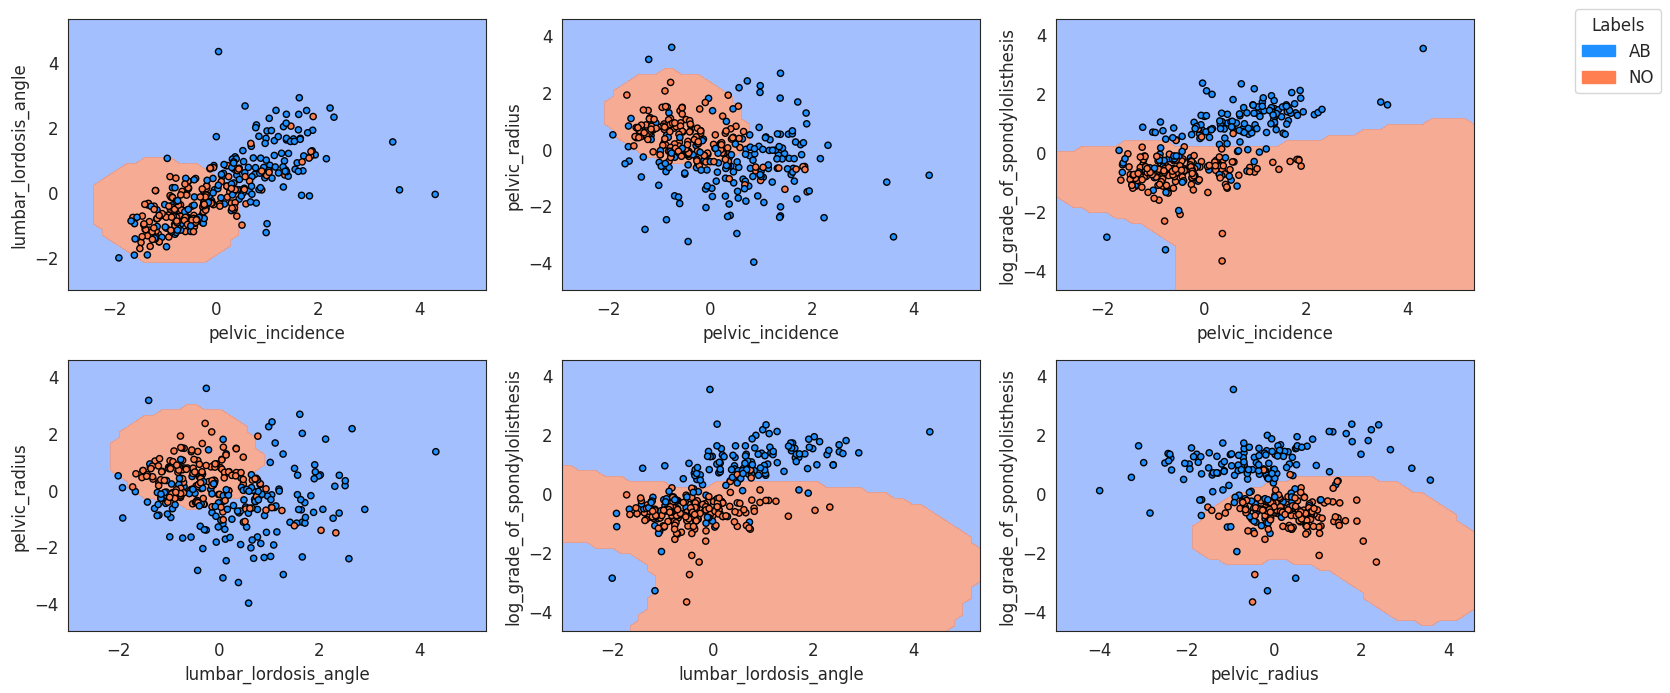

In [ ]:
#draw results for training data

#encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train)

#get unique labels from the training data
unique_labels = np.unique(y_train)
#set label colors
label_colors = {label: color for label, color in zip(unique_labels, ['dodgerblue', 'coral'])}

#plotting for each feature combinations
feature_pairs = combinations(X_subset.columns, 2)
plt.figure(figsize=(15, 7))

for i, (feature1, feature2) in enumerate(feature_pairs, start=1):
    #get the specific pair of features for the current plot
    idx1, idx2 = X_train.columns.get_loc(feature1), X_train.columns.get_loc(feature2)
    X_pair = X_train[[feature1, feature2]]

    #intialise SVM model
    model = SVC(kernel='rbf', gamma=0.1, C=10)
    model.fit(X_pair, y_encoded)

    #plot decision boundaries
    plt.subplot(2, 3, i)
    x_min, x_max = X_pair.iloc[:, 0].min() - 1, X_pair.iloc[:, 0].max() + 1
    y_min, y_max = X_pair.iloc[:, 1].min() - 1, X_pair.iloc[:, 1].max() + 1

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))
    grid_points = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=[feature1, feature2])
    Z = model.predict(grid_points)
    Z = Z.reshape(xx.shape)


    #plot the contour
    plt.contourf(xx, np.array(yy), Z, alpha=0.8, levels=[-1, 0, 1], cmap= 'coolwarm' )
    #plot scatter
    plt.scatter(X_pair[feature1], X_pair[feature2], c=[label_colors[label] for label in y_train], s=20, edgecolors='k')

    plt.xlabel(feature1)
    plt.ylabel(feature2)


#add legend to the plot outside of the subplots
legend= [Patch(color=color, label=label) for label, color in label_colors.items()]
plt.figlegend(handles=legend_handles, title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


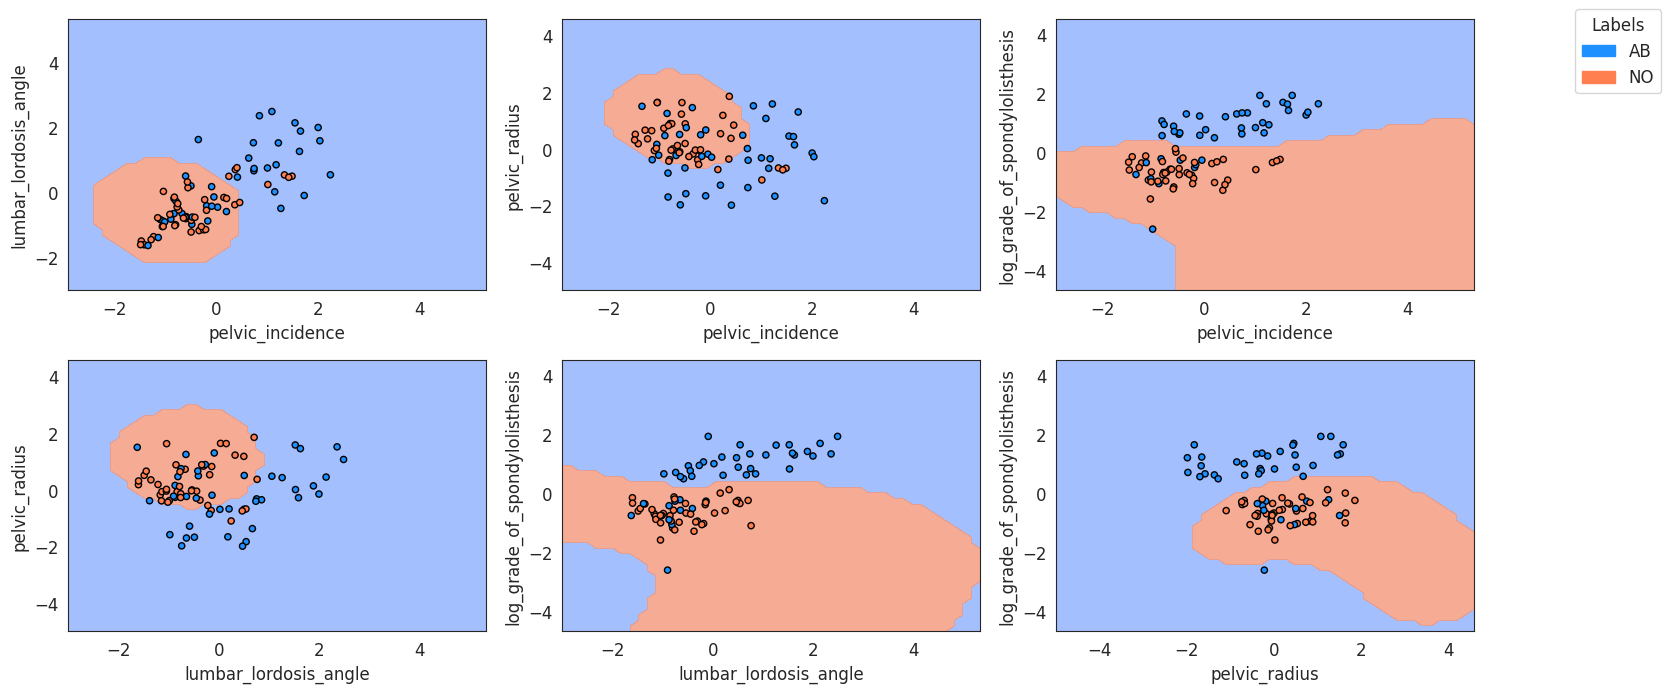

In [ ]:
#draw results for training data

#encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train)

#get unique labels from the training data
unique_labels = np.unique(y_test)
#set label colors
label_colors = {label: color for label, color in zip(unique_labels, ['dodgerblue', 'coral'])}

#plotting for each feature combinations
feature_pairs = combinations(X_subset.columns, 2)
plt.figure(figsize=(15, 7))

for i, (feature1, feature2) in enumerate(feature_pairs, start=1):
    #get the specific pair of features for the current plot
    idx1, idx2 = X_train.columns.get_loc(feature1), X_train.columns.get_loc(feature2)
    X_pair = X_train[[feature1, feature2]]
    X_pair_test = X_test[[feature1, feature2]]

    #initialise SVM model
    model = SVC(kernel='rbf', gamma=0.1, C=10)
    model.fit(X_pair, y_encoded)

    #plot decision boundaries
    plt.subplot(2, 3, i)
    x_min, x_max = X_pair.iloc[:, 0].min() - 1, X_pair.iloc[:, 0].max() + 1
    y_min, y_max = X_pair.iloc[:, 1].min() - 1, X_pair.iloc[:, 1].max() + 1

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))
    grid_points = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=[feature1, feature2])
    Z = model.predict(grid_points)
    Z = Z.reshape(xx.shape)


    #plot the contour
    plt.contourf(xx, np.array(yy), Z, alpha=0.8, levels=[-1, 0, 1], cmap= 'coolwarm' )
    #plot scatter
    plt.scatter(X_pair_test[feature1], X_pair_test[feature2], c=[label_colors[label] for label in y_test], s=20, edgecolors='k')

    plt.xlabel(feature1)
    plt.ylabel(feature2)

# Create legend handles manually
legend_handles = [Patch(color=color, label=label) for label, color in label_colors.items()]

#add legend to the plot outside of the subplots
plt.figlegend(handles=legend_handles, title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
